# Heirarchical Loss Function
> Creating a fine grain image classifier - Pet Breeds!

- toc: true 
- badges: true
- comments: true
- author: Isaac Flath
- categories: [Neural Networks, Image Classification]

# Intro

For this post, I am going to make a modification to the loss function.  The goal will be to weight losses differently.  This post is a work in progress as I try to figure stuff out.

In this blog we are going to do an image classification to take pet pictures and predict the breed.  Normally, each class is treated the same when calculating the loss function.  In this post I will explore a change to take into account weighting classes differently. For example, If a picture is a maincoon, predicting a sphynx (wrong type of cat) is less egregious of an error than predicting pitbull.  I want my loss function to reflect this.

I am going to skim over loading the data and training the model, feel free to see my Fine Grain Image Classifier post from Jun-27-2020 if you want more detail on those aspect.

# Setup

### Library Import and Dataset Download

In [1]:
from fastai2.vision.all import *

seed = 42

# Download and get path for dataseet
path = untar_data(URLs.PETS) #Sample dataset from fastai2
img = (path/'images').ls()[0]

### Data Prep

Load the Data in a data block, take a look at the classes and scale the images down a bit so the problem isn't too easy.

In [2]:
pets = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter= RandomSplitter(valid_pct = 0.2, seed=seed),
    get_y= using_attr(RegexLabeller(r'(.+)_\d+.jpg$'),'name'),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(min_scale = 0.9,size=56)
)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


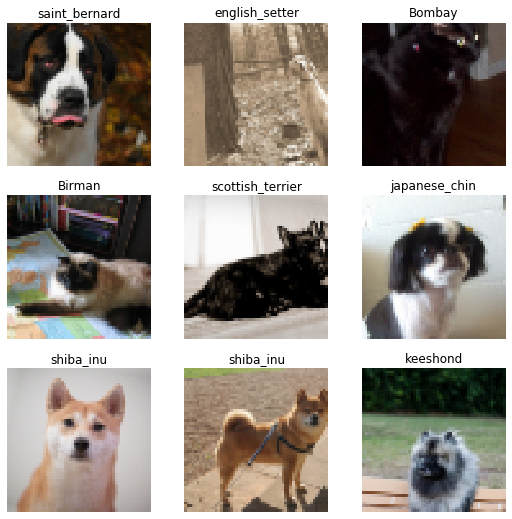

In [3]:
dls = pets.dataloaders(path/"images",bs=64)
dls.show_batch()

In [4]:
# first 12 classes are casts, next 25 are dogs
pet_type = ['cat']*12+['dog']*25

# Custom Stuff

### Metrics

I need to measure the accuracy at the 2 levels in the heirarchy.  The goal is that I can impact them differently by modifying the weights in my loss function.  This will be the metrics to determine is this approach is working or not.

In [5]:
def accuracy_breed(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp.argmax(dim=axis), targ)
    return (pred == targ).float().mean()

def accuracy_species(inp, targ, axis=-1):
    temp = [torch.argmax(x) for x in inp]
    
    new_inp = tensor([(x > 11).int() for x in temp])    
    new_targ = tensor([(x > 11).int() for x in targ])

    return (new_inp == new_targ).float().mean()

### Loss Function

The loss functions are what will actually be optimized.  I am summing a cross entropy loss as the 2 levels of heirarchy.  I then use a weight to change the proportion of which level I use.

In [6]:
from torch.nn.functional import nll_loss,log_softmax



def cross_entropy_species(input, target, weight=None, size_average=None, ignore_index=-100,
                  reduce=None, reduction='mean'):
    
    input_p = torch.softmax(input,dim=-1)
    
    return nll_loss(torch.log(input_p), target, None, None, ignore_index, None, reduction)

def cross_entropy_breed(input, target, weight=None, size_average=None, ignore_index=-100,
                  reduce=None, reduction='mean'):
    
    # softmax to convert scores to probabilities
    input_p = torch.softmax(input,dim=1)
    
    # changes from many classes down to 2 classes for both input and target
    
    # Sum the probabilities for all the cat breeds to get probability it's a cat.  Same for dog
    cats = torch.sum(input_p[:,0:12],dim=1).view(input_p.shape[0],1)
    dogs = torch.sum(input_p[:,12:37],dim=1).view(input_p.shape[0],1)  
    
    # format new inputs and new targets for 2 classes
    new_input = torch.cat([cats,dogs],-1)
    new_target = TensorCategory((target > 11).long(),device='cuda:0')

    return nll_loss(torch.log(new_input), new_target, None, None, ignore_index, None, reduction)

def final_loss(input, target, w=1, weight=None, size_average=None, ignore_index=-100,
                  reduce=None, reduction='mean'):
    ce_species = cross_entropy_species(input, target, weight=None, size_average=None, ignore_index=-100,
                  reduce=None, reduction='mean')
    
    ce_breed = cross_entropy_breed(input, target, weight=None, size_average=None, ignore_index=-100,
                  reduce=None, reduction='mean')
    
    # weighted proportion of these, w should be a number between 0 and 1 ideally.
    return w*ce_species+(1-w)*ce_breed
    

# Expiraments

Run tests for different weights.  Run 5 at each weight so we can see how it performs with random initializations (ie getting stuck in local minimums).

In [7]:
from functools import partial
weights = np.array(range(0,21))/20
results = pd.DataFrame()
id_num = 1
for w in weights:
    for i in range(0,5):
        print(w)
        tmp_loss = partial(final_loss,w=w)
        learn = cnn_learner(dls, resnet18, metrics=[accuracy_breed,accuracy_species], pretrained=True, loss_func = tmp_loss)
        learn.fine_tune(3)

        df = pd.DataFrame(learn.recorder.values)
        df.columns = learn.recorder.metric_names[1:-1]
        df['w'] = w
        df['id'] = id_num
        
        results = results.append(df)
        
        id_num = id_num + 1
        
        learn = None
        torch.cuda.empty_cache()

0.0


0.0


0.0


0.0


0.0


0.05


0.05


0.05


0.05


0.05


0.1


0.1


0.1


0.1


0.1


0.15


0.15


0.15


0.15


0.15


0.2


0.2


0.2


0.2


0.2


0.25


0.25


0.25


0.25


0.25


0.3


0.3


0.3


0.3


0.3


0.35


0.35


0.35


0.35


0.35


0.4


0.4


0.4


0.4


0.4


0.45


0.45


0.45


0.45


0.45


0.5


0.5


0.5


0.5


0.5


0.55


0.55


0.55


0.55


0.55


0.6


0.6


0.6


0.6


0.6


0.65


0.65


0.65


0.65


0.65


0.7


0.7


0.7


0.7


0.7


0.75


0.75


0.75


0.75


0.75


0.8


0.8


0.8


0.8


0.8


0.85


0.85


0.85


0.85


0.85


0.9


0.9


0.9


0.9


0.9


0.95


0.95


0.95


0.95


0.95


1.0


1.0


1.0


1.0


1.0


In [8]:
# Save results for analysis later
results.to_csv('results.csv')

In [9]:
from functools import partial
weights = np.array(range(0,11))/10
results = pd.DataFrame()
id_num = 1
for w in weights:
    for i in range(0,5):
        print(w)
        tmp_loss = partial(final_loss,w=w)
        learn = cnn_learner(dls, resnet18, metrics=[accuracy_breed,accuracy_species], pretrained=True, loss_func = tmp_loss)
        learn.fine_tune(10)

        df = pd.DataFrame(learn.recorder.values)
        df.columns = learn.recorder.metric_names[1:-1]
        df['w'] = w
        df['id'] = id_num
        
        results = results.append(df)
        
        id_num = id_num + 1
        
        learn = None
        torch.cuda.empty_cache()

0.0


/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


0.0


0.0


0.0


0.0


0.1


0.1


0.1


0.1


0.1


0.2


0.2


0.2


0.2


0.2


0.3


0.3


0.3


0.3


0.3


0.4


0.4


0.4


0.4


0.4


0.5


0.5


0.5


0.5


0.5


0.6


0.6


0.6


0.6


0.6


0.7


0.7


0.7


0.7


0.7


0.8


0.8


0.8


0.8


0.8


0.9


0.9


0.9


0.9


0.9


1.0


1.0


1.0


1.0


1.0


In [10]:
# Save results for analysis later
results.to_csv('results2.csv')